In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.cluster import KMeans
from scipy.optimize import curve_fit

In [47]:
df = pd.read_csv('./wb_data.csv')

In [48]:
df.head()

,Series Name,Series Code,Country Name,Country Code,2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],...,2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020]
0,"Population, total",SP.POP.TOTL,Afghanistan,AFG,19542982,19688632,21000256,22645130,23553551,24411191,...,29249157,30466479,31541209,32716210,33753499,34636207,35643418,36686784,37769499,38972230
1,"Population, total",SP.POP.TOTL,Albania,ALB,3089027,3060173,3051010,3039616,3026939,3011487,...,2905195,2900401,2895092,2889104,2880703,2876101,2873457,2866376,2854191,2837849
2,"Population, total",SP.POP.TOTL,Algeria,DZA,30774621,31200985,31624696,32055883,32510186,32956690,...,36543541,37260563,38000626,38760168,39543154,40339329,41136546,41927007,42705368,43451666
3,"Population, total",SP.POP.TOTL,American Samoa,ASM,58230,58324,58177,57941,57626,57254,...,54310,53691,52995,52217,51368,50448,49463,48424,47321,46189
4,"Population, total",SP.POP.TOTL,Andorra,AND,66097,67820,70849,73907,76933,79826,...,70567,71013,71367,71621,71746,72540,73837,75013,76343,77700


In [49]:
# Extract unique Series Code into a list
unique_series_code = df['Series Code'].unique().tolist()
print(unique_series_code)

['SP.POP.TOTL', 'EN.ATM.CO2E.KT', 'NY.GDP.MKTP.KN']


In [50]:
# Filter the dataset for population and GDP series
population_data = df[df['Series Name'] == 'Population, total']
gdp_data = df[df['Series Name'] == 'GDP (constant LCU)']

# Drop unnecessary columns
population_data = population_data.drop(columns=['Series Name', 'Series Code'])
gdp_data = gdp_data.drop(columns=['Series Name', 'Series Code'])

# Rename the yearly columns to a common format for merging
columns_rename = {year: year[-9:] for year in population_data.columns if 'YR' in year}
population_data.rename(columns=columns_rename, inplace=True)
gdp_data.rename(columns=columns_rename, inplace=True)

# Melt the dataframes to have one row per country-year
population_melted = population_data.melt(id_vars=['Country Name', 'Country Code'], var_name='Year', value_name='Population_Value')
gdp_melted = gdp_data.melt(id_vars=['Country Name', 'Country Code'], var_name='Year', value_name='GDP_Value')

# Merge the population and GDP data on country and year
merged_data = pd.merge(population_melted, gdp_melted, on=['Country Name', 'Country Code', 'Year'])

# Convert the 'Population_Value' and 'GDP_Value' columns to numeric, coercing non-numeric values to NaN
merged_data['Population_Value'] = pd.to_numeric(merged_data['Population_Value'], errors='coerce')
merged_data['GDP_Value'] = pd.to_numeric(merged_data['GDP_Value'], errors='coerce')

# Drop rows with NaN values in 'Population_Value' or 'GDP_Value'
merged_data_clean = merged_data.dropna(subset=['Population_Value', 'GDP_Value'])

# Calculate the correlation between population and GDP for each country with cleaned data
correlations = {}
for country in merged_data_clean['Country Name'].unique():
    country_data = merged_data_clean[merged_data_clean['Country Name'] == country]
    correlation = country_data[['Population_Value', 'GDP_Value']].corr().iloc[0, 1]
    correlations[country] = correlation

# Convert the correlations dictionary to a DataFrame for plotting
correlation_df = pd.DataFrame(list(correlations.items()), columns=['Country', 'Correlation'])

# Sort the DataFrame based on the absolute value of the correlation to get meaningful order
sorted_correlation_df = correlation_df.reindex(correlation_df.Correlation.abs().sort_values(ascending=False).index)

# Display the sorted correlation DataFrame
print(sorted_correlation_df.tail())

              Country  Correlation
194       Yemen, Rep.    -0.119439
62   French Polynesia     0.117488
144          Portugal    -0.108075
66            Germany     0.062900
102             Libya     0.055173


In [51]:
def fit(x, a, b):
    return a * x + b

# Define the error ranges function
def ranges(x, popt, pcov):
    perr = np.sqrt(np.diag(pcov))
    y = fit(x, *popt)
    y_upper = fit(x, *(popt + perr))
    y_lower = fit(x, *(popt - perr))
    return y, y_lower, y_upper

/var/folders/89/c7y7lbhd361_jgzcg19_qsy40000gn/T/ipykernel_12744/3149175155.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(combined_data['Second Series'], combined_data['First Series'], cmap='inferno', label='Data Points')


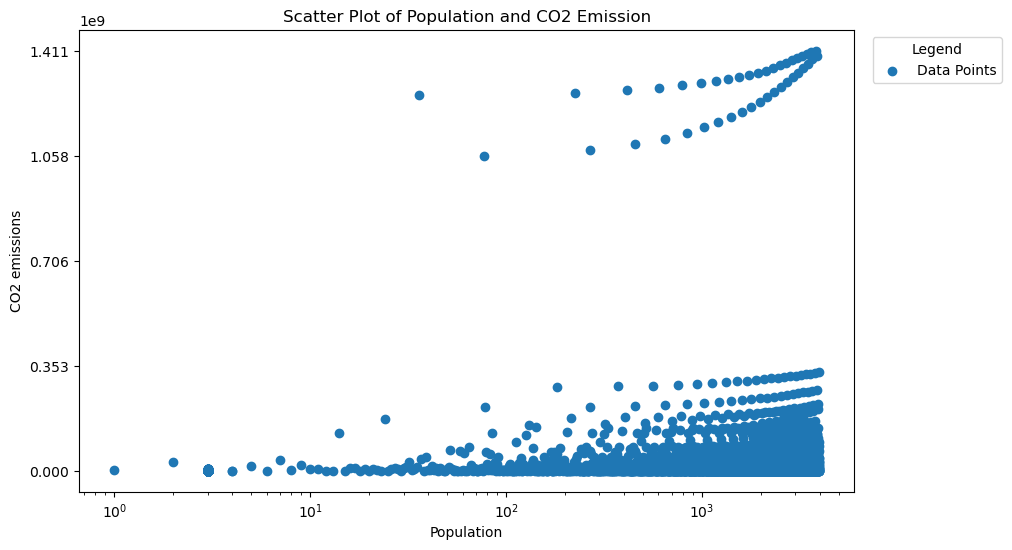

In [52]:
def plot_scatter(series_x, series_y, title):
    file_path = 'wb_data.csv'
    data = pd.read_csv(file_path, encoding='ascii')

    electricity_access = data[data['Series Code'] == series_x]
    total_population = data[data['Series Code'] == series_y]

    # Since the data is in wide format, we need to melt it to long format
    series_a = electricity_access.melt(id_vars=['Country Name', 'Country Code'],
                                       value_vars=electricity_access.columns[4:],
                                       var_name='Year', value_name='First Series')
    series_b = total_population.melt(id_vars=['Country Name', 'Country Code'],
                                     value_vars=total_population.columns[4:],
                                     var_name='Year', value_name='Second Series')

    # Merge the two datasets on 'Country Code' and 'Year'
    combined_data = pd.merge(series_a, series_b, on=['Country Code', 'Year'])

    # Convert 'Year' to datetime and extract the year for plotting
    combined_data['Year'] = pd.to_datetime(combined_data['Year'].str.extract('(\d{4})')[0]).dt.year

    # Convert 'First Series' to numeric, coercing errors to NaN
    combined_data['First Series'] = pd.to_numeric(combined_data['First Series'], errors='coerce')

    # Drop rows with NaN values in 'First Series'
    combined_data = combined_data.dropna(subset=['First Series'])

    # Drop rows with NaN values in 'Second Series' (population)
    combined_data = combined_data.dropna(subset=['Second Series'])

    # Plotting with specified number of ticks on the Y axis
    plt.figure(figsize=(10, 6))
    plt.scatter(combined_data['Second Series'], combined_data['First Series'], cmap='inferno', label='Data Points')
    plt.title(title)
    plt.xlabel('Population')
    plt.ylabel('CO2 emissions')
    plt.xscale('log')  # Using a log scale for better visualization

    # Set the number of ticks on the Y axis to 5
    plt.yticks(np.linspace(combined_data['First Series'].min(), combined_data['First Series'].max(), 5))

    # Add legend with color codes
    plt.legend(title='Legend', loc='upper right', bbox_to_anchor=(1.2, 1))

    return plt.show()

# Example usage:
plot_scatter('SP.POP.TOTL', 'EN.ATM.CO2E.KT', 'Scatter Plot of Population and CO2 Emission')


In [54]:
def plot_country_confidence(df, country_name, series_code, title):
    # Filter the data for India and the series code 'NY.GNP.MKTP.CD'
    selected_country = df[(df['Country Name'] == country_name) & (df['Series Code'] == series_code)]

    # Drop the non-year columns to focus on the yearly data
    sel_columns = ['Series Name', 'Series Code', 'Country Name', 'Country Code']
    selected_country_years = selected_country.drop(columns=sel_columns)


    # Since there was an error with 'Unnamed: 0', we will exclude it from the drop
    selected_country_years = selected_country.drop(columns=sel_columns)

    # Transpose the data to have years as rows
    selected_country_transposed = selected_country_years.transpose()
    selected_country_transposed.columns = ['GNP']

    # Reset index to have years as a column
    selected_country_transposed.reset_index(inplace=True)
    selected_country_transposed.rename(columns={'index': 'Year'}, inplace=True)

    # Extract year from the column name and convert to integer
    selected_country_transposed['Year'] = selected_country_transposed['Year'].str.extract('(\d+)').astype(int)

    # Convert GNP column to numeric, coerce errors to NaN
    selected_country_transposed['GNP'] = pd.to_numeric(selected_country_transposed['GNP'], errors='coerce')

    # Drop rows with NaN values
    selected_country_cleaned = selected_country_transposed.dropna()

    # Fit the linear model to the data
    popt, pcov = curve_fit(fit, selected_country_cleaned['Year'], selected_country_cleaned['GNP'])

    # Generate the confidence range
    years = np.array(selected_country_cleaned['Year'])
    GNP, GNP_lower, GNP_upper = ranges(years, popt, pcov)

    # Plot the data
    plt.figure(figsize=(14, 7))
    plt.plot(selected_country_cleaned['Year'], selected_country_cleaned['GNP'], 'o', label='Data')
    plt.plot(years, GNP, '-', label='Fit')
    plt.fill_between(years, GNP_lower, GNP_upper, color='gray', alpha=0.2, label='Confidence range')

    # Label the plot
    plt.xlabel('Year')
    plt.ylabel('GNP (current US$)')
    plt.title('GNP of United Kingdom with Confidence Range')
    plt.legend()

    # Show the plot
    plt.show()

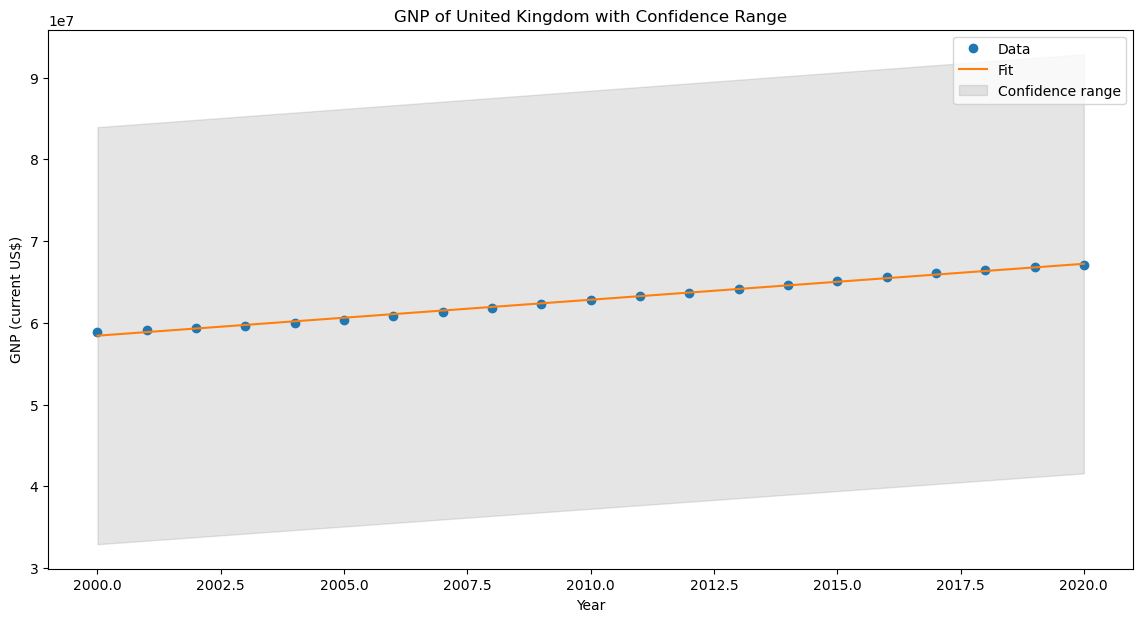

In [55]:
country_name = 'United Kingdom'
series_code = 'SP.POP.TOTL'
title = ''
plot_country_confidence(df, country_name, series_code, title)

In [66]:
def cluster_plot(df, series_name_y, series_name_x, n_clusters):
    first_series = df[df['Series Code'] == series_name_y]
    second_series = df[df['Series Code'] == series_name_x]

    # Melt the dataframes
    first_series_melted = first_series.melt(id_vars=['Country Name', 'Country Code'], 
                                          value_vars=first_series.columns[4:], 
                                          var_name='Year', value_name='CO2 emissions (kt)')
    second_series_melted = second_series.melt(id_vars=['Country Name', 'Country Code'], 
                                                  value_vars=second_series.columns[4:], 
                                                  var_name='Year', value_name='Population, total')

    # Merge the two datasets on 'Country Code' and 'Year'
    joined = pd.merge(first_series_melted, second_series_melted, on=['Country Code', 'Year'])

    # Convert 'Year' to datetime and extract the year for plotting
    joined['Year'] = pd.to_datetime(joined['Year'].str.extract('(\d{4})')[0]).dt.year

    # Convert to numeric and drop NaNs
    joined['CO2 emissions (kt)'] = pd.to_numeric(joined['CO2 emissions (kt)'], errors='coerce')
    joined['Population, total'] = pd.to_numeric(joined['Population, total'], errors='coerce')
    joined.dropna(subset=['CO2 emissions (kt)', 'Population, total'], inplace=True)

    # Prepare the data for clustering
    X = joined[['CO2 emissions (kt)', 'Population, total']]

    # Use KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

    # Assign the clusters to the dataframe
    joined['Cluster'] = kmeans.labels_

    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=joined, x='Population, total', y='CO2 emissions (kt)', hue='Cluster')
    plt.title('Clustering of CO2 emissions (kt) and Population, total')
    plt.xlabel('Population, total')
    plt.ylabel('CO2 emissions (kt)')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(title='Cluster')
    return plt.show()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


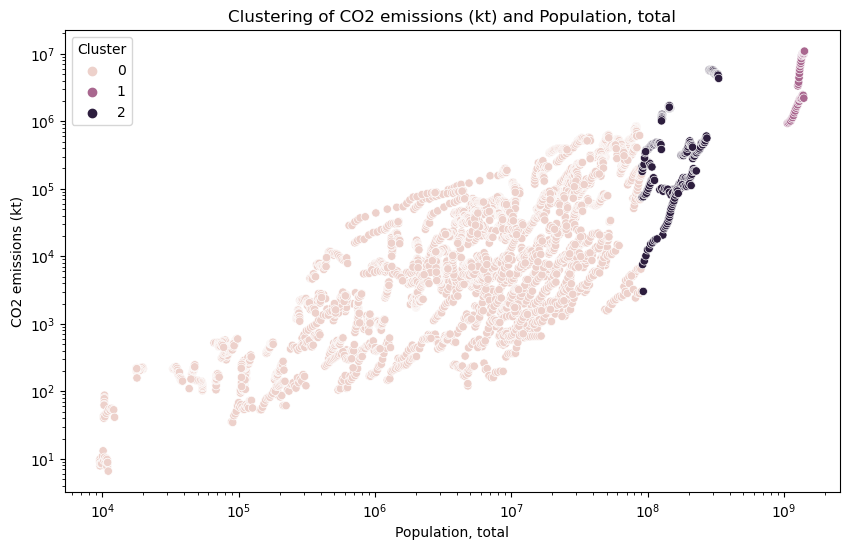

In [67]:
cluster_plot(df, 'EN.ATM.CO2E.KT', 'SP.POP.TOTL', 3)

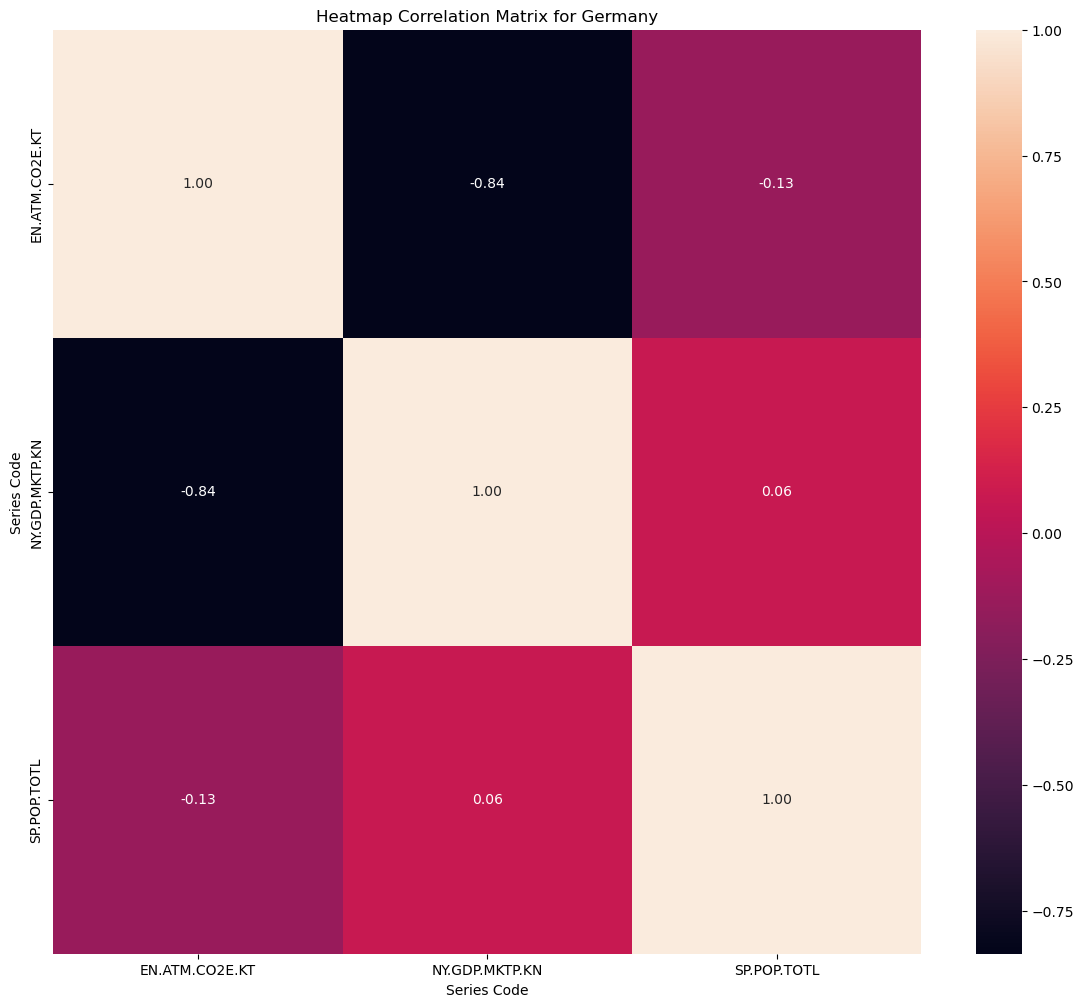

In [64]:
def country_corr(df, country_name):
    df = pd.read_csv('wb_data.csv', encoding='ascii')

    # Filter the dataframe for Country
    country_df = df[df['Country Name'] == country_name]

    # Replace '..' with NaN to ensure proper numeric conversion
    country_df = country_df.replace('..', pd.NA)

    # Convert all columns to numeric, except 'Series Code', coercing errors to NaN
    numeric_columns = country_df.columns.drop(['Series Name', 'Series Code', 'Country Name', 'Country Code'])
    country_df[numeric_columns] = country_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Drop non-numeric columns except 'Series Code' and columns with all NaN values
    country_df = country_df.drop(columns=['Series Name', 'Country Code'])
    country_df = country_df.dropna(axis=1, how='all')

    # Now we will create a correlation matrix for each unique 'Series Code'
    # First, we need to pivot the dataframe so that each 'Series Code' becomes a row
    china_pivoted = country_df.pivot(index='Series Code', columns='Country Name', values=numeric_columns)
    correlation_matrix_pivoted = china_pivoted.T.corr()

    # Plot the heatmap
    plt.figure(figsize=(14, 12))
    sns.heatmap(correlation_matrix_pivoted, annot=True, fmt='.2f')
    plt.title('Heatmap Correlation Matrix for Germany')
    return plt.show()


country_corr(df, 'Germany')

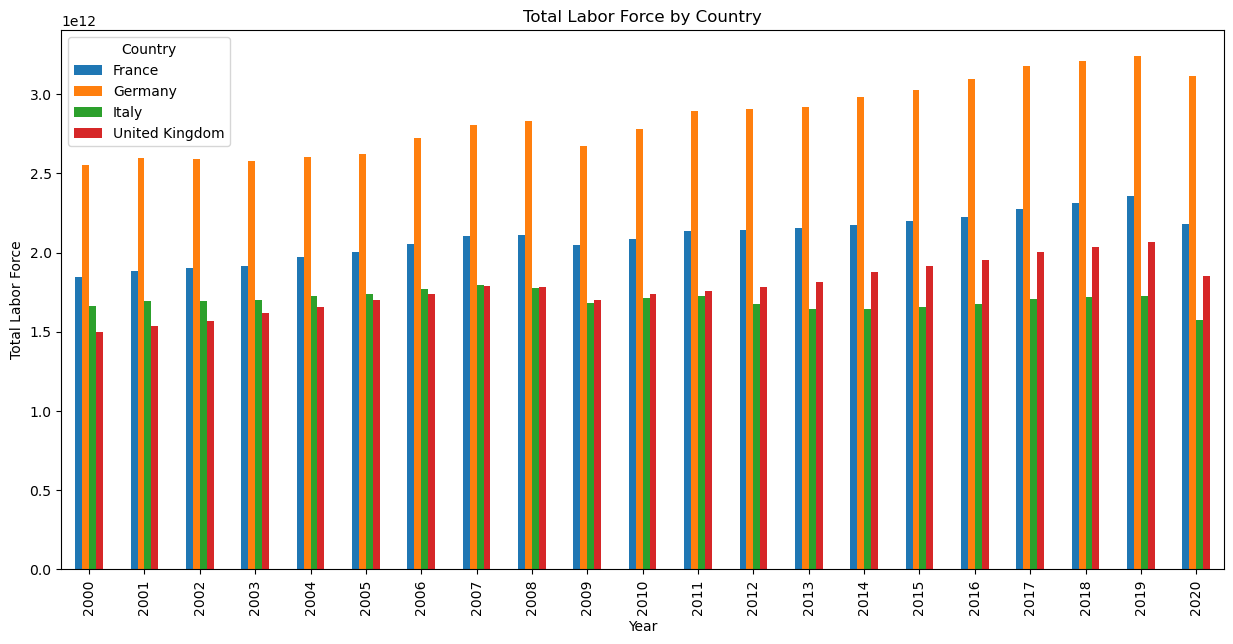

In [65]:
def plot_country_labour():
    # Filter the dataset for the required countries and indicator
    filtered_data = df[(df['Country Name'].isin(['United Kingdom', 'France', 'Italy', 'Germany'])) & (df['Series Code'] == 'NY.GDP.MKTP.KN')]

    # Since the years are in separate columns, we need to melt the dataframe to have a single year column
    melted_data = pd.melt(filtered_data, id_vars=['Country Name'], value_vars=[str(year) + ' [YR' + str(year) + ']' for year in range(2000, 2021)],
                           var_name='Year', value_name='Total Labor Force')

    # Convert the 'Year' column to just the year number
    melted_data['Year'] = melted_data['Year'].str.extract('(\\d{4})').astype(int)

    # Pivot the data to have countries as columns and years as rows for plotting
    pivoted_data = melted_data.pivot(index='Year', columns='Country Name', values='Total Labor Force')

    # Convert non-numeric data to numeric, coerce errors to 
    pivoted_data = pivoted_data.apply(pd.to_numeric, errors='coerce')

    # Plot the grouped bar chart
    pivoted_data.plot(kind='bar', figsize=(15, 7))
    plt.title('Total Labor Force by Country')
    plt.xlabel('Year')
    plt.ylabel('Total Labor Force')
    plt.legend(title='Country')
    return plt.show()

plot_country_labour()